In [1]:
import wfdb
import os
import numpy as np
import pandas as pd
import warnings
import random
import pickle
import matplotlib.pyplot as plt
from ripser import Rips
from persim import PersistenceImager, PersistenceLandscaper
from scipy.stats import skew, kurtosis
warnings.filterwarnings("ignore")

mother_dir = "/Users/arshaniksa/Desktop/SUT/1403 - 2 - Semester 8/BSc Project/Data/VR Eyes/archive/"
random_state = 42
n_trees = 100
n_points = 10
n_window = 25

os.chdir(mother_dir + "04 Eye Tracking Data/01 Eye Tracking Data (Pre-Processed)/")


gaze_data = []
files = os.listdir()
for file in files:
    if file[-4:] == ".dat":
        datum = []
        with open(file, 'rb') as f:
            data_dict = pickle.load(f)
            labels = data_dict['Labels']
            data = data_dict['Data']
        datum.append(labels)
        datum.append(data)
        gaze_data.append(datum)

reduction_factor = 20
def reduce(trajectory):
    new_traj = []
    i = 0
    while i < np.shape(trajectory)[0]:
        new_traj.append([trajectory[i,0], trajectory[i,1], trajectory[i,2]])
        i += reduction_factor
    trj = np.zeros((len(new_traj), 3))
    for i in range(len(new_traj)):
        trj[i, 0] = new_traj[i][0]
        trj[i, 1] = new_traj[i][1]
        trj[i, 2] = new_traj[i][2]
    return trj

def split_data(data, ratios):
    first_seperator = int(len(data) * ratios[0])
    return (data[0:first_seperator], data[first_seperator:])

flat_gaze = []
for i in range(len(gaze_data)):
    for j in range(12):
        datum = []
        try:
            datum.append(reduce(np.transpose(gaze_data[i][1][j][[1,2,3], :])))
            datum.append(gaze_data[i][0][j][0])
            flat_gaze.append(datum)
        except:
            continue
random.Random(random_state).shuffle(flat_gaze)

ratios = [0.8, 0.2]
train_data, exam_data = split_data(flat_gaze, ratios)

In [2]:
def embed_time_series(time_series, d, tau):
    embedded = np.zeros((len(time_series) - d * tau, d))
    for i in range(len(time_series) - d * tau):
        for j in range(d):
            embedded[i, j] = time_series[i + j * tau]
    return embedded

def get_vect(trajectory):
    ls = get_diagram(trajectory[:,[0,1]])
    birth = ls[0]
    pers = ls[1]
    vect = tda_feature_vector_from_birth_pers(birth, pers)
    ls = get_diagram(embed_time_series(trajectory[:,0], 3, 10))
    birth = ls[0]
    pers = ls[1]
    vect.extend(tda_feature_vector_from_birth_pers(birth, pers))
    ls = get_diagram(embed_time_series(trajectory[:,1], 3, 10))
    birth = ls[0]
    pers = ls[1]
    vect.extend(tda_feature_vector_from_birth_pers(birth, pers))
    ls = get_H0(trajectory[:,[0,1]])
    birth = ls[0]
    pers = ls[1]
    vect.extend(tda_feature_vector_from_birth_pers(birth, pers))
    return vect

def get_H0(trajectory):
    rips = Rips(verbose = False)
    dgms = rips.fit_transform(trajectory)
    H1_dgm = dgms[0]

    birth = []
    pers = []
    for i in range(len(H1_dgm)):
        if not np.isinf(H1_dgm[i][1]):
            birth.append((H1_dgm[i][0] + H1_dgm[i][1]) / 2)
            pers.append(H1_dgm[i][1] - H1_dgm[i][0])
    return [birth, pers]

def get_diagram(trajectory):
    rips = Rips(verbose = False)
    dgms = rips.fit_transform(trajectory)
    H1_dgm = dgms[1]

    birth = []
    pers = []
    for i in range(len(H1_dgm)):
        if not np.isinf(H1_dgm[i][1]):
            birth.append((H1_dgm[i][0] + H1_dgm[i][1]) / 2)
            pers.append(H1_dgm[i][1] - H1_dgm[i][0])
    return [birth, pers]

def get_stats(list):
    probs = list / np.sum(list)
    entropy = -np.sum(probs * np.log(probs))
    return [
        np.max(list),                   # Max
        np.mean(list),                  # Mean
        entropy                   # persistence entropy
    ]

def tda_feature_vector_from_birth_pers(births, pers):
    if len(pers) == 0 or np.sum(pers) == 0:
        return [0] * 8  # return zeros if no features

    births = np.array(births)
    pers = np.array(pers)
    deaths = births + pers

    ls = [len(births)]
    ls.extend(get_stats(births))
    ls.extend(get_stats(pers))
    ls.extend(get_stats(deaths))
    return ls

In [3]:
def get_df(data):
    rows = []
    for i in range(len(data)):
        print(str(i) + " " + str(len(data)), end = "\r")
        row = []
        row.append(data[i][1])
        row.extend(get_vect(data[i][0]))
        rows.append(row)
    return pd.DataFrame(rows)

df = get_df(train_data)
df

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,2.0,94,19.835064,5.038119,4.237191,7.705455,0.875012,3.866715,21.898080,5.913131,...,592.0,50.166183,1.075810,5.749102,100.332367,2.151619,5.749102,150.498550,3.227429,5.749102
1,3.0,43,17.023274,3.321851,3.477347,4.062319,0.483502,3.054361,21.085593,3.805353,...,272.0,71.783600,0.950841,4.294793,143.567200,1.901682,4.294793,215.350800,2.852523,4.294793
2,3.0,67,24.870489,4.205294,3.826013,6.850445,0.570526,3.439451,31.720934,4.775819,...,415.0,55.569000,1.001381,5.201171,111.138000,2.002762,5.201171,166.707001,3.004143,5.201171
3,1.0,97,15.436281,4.658226,4.433989,4.306355,0.700235,4.123550,19.742636,5.358461,...,557.0,55.109959,1.104687,5.779271,110.219917,2.209374,5.779271,165.329876,3.314061,5.779271
4,3.0,46,28.263892,4.553393,3.472820,1.865090,0.458769,3.400648,28.578801,5.012162,...,413.0,57.022839,1.035678,5.057148,114.045677,2.071356,5.057148,171.068516,3.107035,5.057148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,2.0,104,22.809558,5.464097,4.320847,7.159948,0.888694,4.034723,27.472077,6.352790,...,597.0,52.727612,1.159470,5.741462,105.455223,2.318939,5.741462,158.182835,3.478409,5.741462
315,3.0,58,10.837323,1.939470,3.708127,1.743153,0.312692,3.345546,11.614108,2.252162,...,398.0,83.816139,0.638158,4.225269,167.632278,1.276316,4.225269,251.448418,1.914473,4.225269
316,0.0,51,39.328780,4.948061,3.331291,29.362116,1.153447,2.179731,68.690896,6.101508,...,451.0,48.016613,1.128954,5.080886,96.033226,2.257909,5.080886,144.049839,3.386863,5.080886
317,1.0,94,28.049559,8.003939,4.346420,10.595617,1.427958,3.880340,29.549273,9.431897,...,583.0,52.663013,1.580117,5.919649,105.326027,3.160234,5.919649,157.989040,4.740351,5.919649


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X, y = df.iloc[:, 1:], df.iloc[:, 0]
features_train, features_test, labels_train, labels_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
print(features_train)
random_forest = RandomForestClassifier(n_estimators=n_trees, random_state=random_state)
random_forest.fit(features_train, labels_train)
rf_pred = random_forest.predict(features_test)
print(accuracy_score(labels_test, rf_pred))

from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(labels_test, rf_pred)
matrix.diagonal()/matrix.sum(axis=1)

     1           2          3         4          5         6         7   \
210  87   29.083868   7.644296  4.043611  18.160075  1.274111  3.586191   
76   80  131.224113  10.297658  3.943783  14.416668  1.669228  3.653804   
94   38   33.780663   7.599483  3.291358   2.984055  0.745105  3.149647   
222  23   10.105376   4.583182  2.990451   0.971495  0.406478  2.835543   
311  78   28.617685   7.294233  3.953155   8.769686  1.186374  3.441696   
..   ..         ...        ...       ...        ...       ...       ...   
188  30   25.426510   6.691689  2.938223   3.825859  0.782938  2.620252   
71   86   30.024679   3.830142  3.785980   7.606674  0.590684  3.472901   
106  53    6.996118   2.717336  3.844571   1.984528  0.372320  3.426526   
270  68   15.658002   4.718457  3.964376   6.692923  0.864530  3.439590   
102  95   34.518571   4.902970  4.366828   6.299475  0.794992  4.000345   

             8          9         10  ...     31         32        33  \
210   42.112844   8.918407

array([0.86666667, 0.77272727, 0.58333333, 0.73333333])

Accuracy: 0.750
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.81      0.77      0.79        22
           2       0.54      0.58      0.56        12
           3       0.79      0.73      0.76        15

    accuracy                           0.75        64
   macro avg       0.74      0.74      0.74        64
weighted avg       0.75      0.75      0.75        64



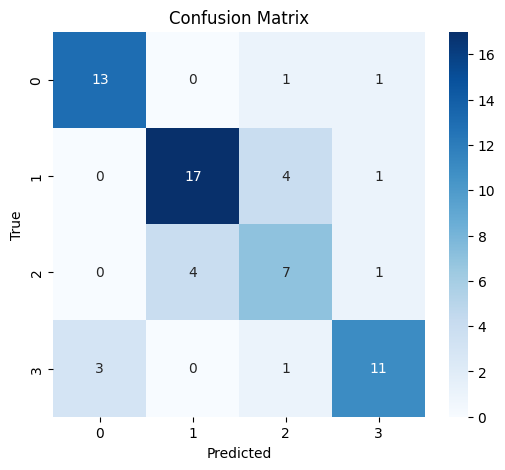

In [5]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(y_true, predicted_labels, class_names=None, title="Confusion Matrix"):
    test_accuracy = accuracy_score(y_true, predicted_labels)
    report = classification_report(y_true, predicted_labels, target_names=class_names)
    cm = confusion_matrix(y_true, predicted_labels)

    print(f"Accuracy: {test_accuracy:.3f}")
    print("Classification Report:")
    print(report)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# Example usage:
evaluate_model(labels_test, rf_pred, class_names=["0", "1", "2", "3"])


In [6]:
n = 0
m = 0
for i in range(len(exam_data)):
    if random_forest.predict(np.reshape(get_vect(exam_data[i][0]), (1,40)))[0] == exam_data[i][1]:
        n += 1
    m += 1
    print(n/m, end = "\r")